# Clustering

In [2]:
# %matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from hdbscan import HDBSCAN
from mpl_toolkits.mplot3d import Axes3D

In [38]:
dateparse = lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M:%S%z")  # pd.datetime.strptime

core_users_to_cluster = pd.read_csv("../data/core_users_to_cluster.csv",
                    parse_dates=['created_at'],
                    converters={"user_id": str})

In [39]:
core_users_clustered = core_users_to_cluster.copy()

## Data preprocessing

Selezione delle features e standardizzazione dei dati.

In [40]:
# Seleziona le caratteristiche da utilizzare per il clustering
# all_features = ['nbr_followers', 'nbr_followings', 'nbr_liked_tweets', 'nbr_lists', 'nbr_tweets', 'nbr_usernames', 'following_ratio', 'followers_ratio', 'favorites_ratio', 'tweet_ratio']
all_features = ['nbr_liked_tweets', 'nbr_lists', 'nbr_tweets', 'nbr_usernames', 'nbr_followings', 'nbr_followers', 'favorites_ratio', 'followers_ratio', 'has_url', 'bio_sentences', 'bio_tokens', 'bio_characters', 'has_bio', 'account_age', 'following_ratio', 'tweet_ratio', 'retweet_ratio', 'reply_ratio', 'tweet_url_ratio', 'retweet_url_ratio', 'reply_url_ratio', 'words_in_tweets_median', 'unique_words_entropy', 'language_novelty', 'median_time_between_tweets', 'median_time_between_retweets', 'median_time_between_mentions', 'nbr_retweeted_accounts', 'nbr_domains_mean', 'median_words_count', 'median_char_count']

credibility_features = ['nbr_followings', 'nbr_followers', 'favorites_ratio', 'followers_ratio', 'has_url', 'bio_sentences', 'bio_tokens', 'bio_characters', 'has_bio', 'account_age', 'following_ratio', 'tweet_ratio']
initiative_features = ['retweet_ratio', 'reply_ratio', 'tweet_url_ratio', 'retweet_url_ratio', 'reply_url_ratio', 'words_in_tweets_median', 'unique_words_entropy']
adaptability_features = ['language_novelty', 'median_time_between_tweets', 'median_time_between_retweets', 'median_time_between_mentions', 'nbr_retweeted_accounts', 'nbr_domains_mean', 'median_words_count', 'median_char_count']


# Standardizzazione delle features
core_users_standardized = (core_users_clustered[all_features] - core_users_clustered[all_features].mean()) / core_users_clustered[all_features].std()
# Normalizzazione delle features
# core_users_normalized = (core_users_clustering[all_features] - core_users_clustering[all_features].min()) / (core_users_clustering[all_features].max() - core_users_clustering[all_features].min())


# Sostituisci i valori mancanti con 0
core_users_standardized = core_users_standardized.fillna(0)

Calcolo della varianza spiegata cumulativa per determinare il numero di componenti da utilizzare per la PCA.

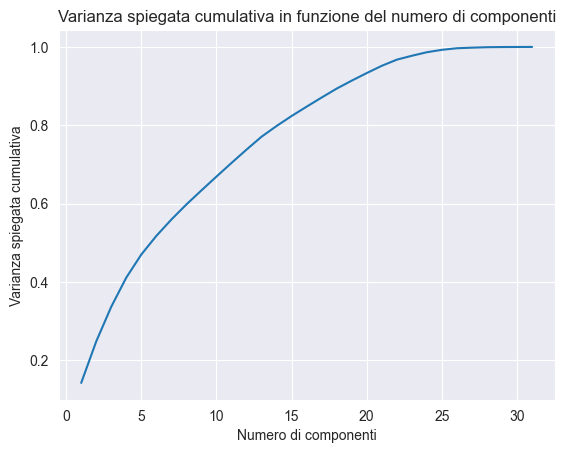

In [41]:
# PCA senza riduzione di dimensioni
pca = PCA()
core_users_pca = pca.fit(core_users_standardized)

# Calcola la varianza spiegata cumulativa
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Visualizza la varianza spiegata cumulativa
plt.plot(range(1,len(explained_variance)+1), explained_variance)
plt.title('Varianza spiegata cumulativa in funzione del numero di componenti')
plt.xlabel('Numero di componenti')
plt.ylabel('Varianza spiegata cumulativa')
plt.show()


# pca_calculation = [core_users_standardized_all, core_users_standardized_credibility, core_users_standardized_initiative, core_users_standardized_adaptability]
# core_users_pca = []
# 
# for i in range(len(pca_calculation)):
#     pca = PCA()
#     core_users_pca.append(pca.fit(pca_calculation[i]))
# 
#     # Calcola la varianza spiegata cumulativa
#     explained_variance = np.cumsum(pca.explained_variance_ratio_)
# 
#     # Visualizza la varianza spiegata cumulativa
#     plt.plot(range(1,len(explained_variance)+1), explained_variance)
#     plt.title('Varianza spiegata cumulativa in funzione del numero di componenti')
#     plt.xlabel('Numero di componenti')
#     plt.ylabel('Varianza spiegata cumulativa')
#     plt.show()
    

Applicazione della PCA per ridurre le dimensioni del dataset e utilizzo dell'Eblow Method per determinare il numero di cluster da utilizzare.

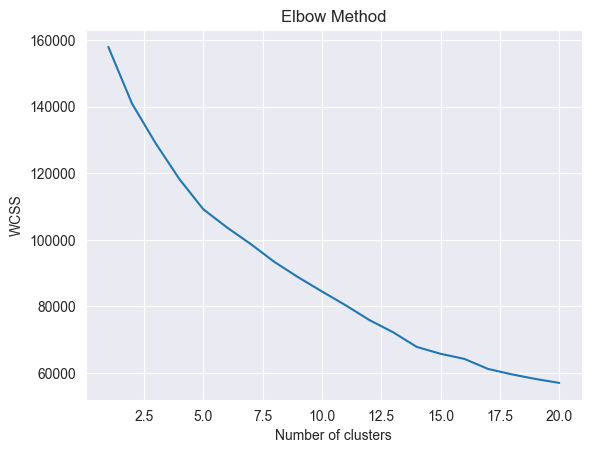

In [42]:
# Applica PCA
pca = PCA(n_components=14)
core_users_pca = pca.fit_transform(core_users_standardized)

# Calcola la WCSS per diverse quantità di cluster
wcss = []
for i in range(1, 21):
    kmeans = KMeans(n_clusters=i, n_init=20, random_state=0).fit(core_users_pca)
    wcss.append(kmeans.inertia_)

# Visualizza la WCSS in funzione del numero di cluster
plt.plot(range(1, 21), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



# wcss_calculation = [core_users_standardized_all, core_users_standardized_credibility, core_users_standardized_initiative, core_users_standardized_adaptability]
# core_users_pca = []
# n_components = [2, 2, 2, 2]
# 
# for i in range(len(wcss_calculation)):
#     # Applica PCA
#     pca = PCA(n_components=n_components[i])
#     current_pca = pca.fit_transform(wcss_calculation[i])
#     core_users_pca.append(current_pca)  # Salva la matrice PCA nella lista
# 
#     # Calcola la WCSS per diverse quantità di cluster
#     wcss = []
#     for j in range(1, 21):
#         kmeans = KMeans(n_clusters=j, n_init=20, random_state=0).fit(current_pca)
#         wcss.append(kmeans.inertia_)
# 
#     # Visualizza la WCSS in funzione del numero di cluster
#     plt.plot(range(1, 21), wcss)
#     plt.title('Elbow Method')
#     plt.xlabel('Number of clusters')
#     plt.ylabel('WCSS')
#     plt.show()

## K-Means algorithm

C:\Users\davis\miniconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


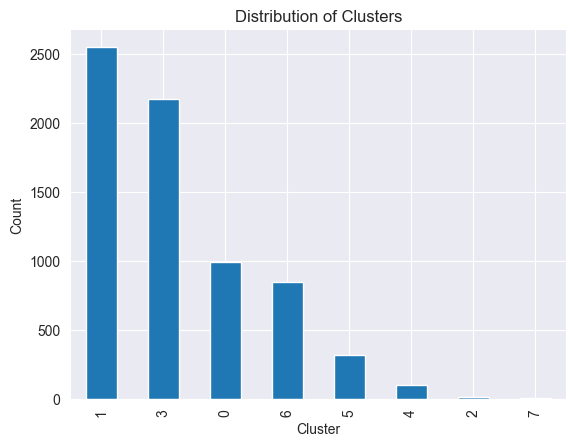

In [43]:
# Esegui il clustering K-means
kmeans = KMeans(n_clusters=8, random_state=0).fit(core_users_pca)

# Aggiungi le etichette dei cluster ai dati
core_users_clustered['kmeans_cluster_all'] = kmeans.labels_

# Visualizza la distribuzione dei cluster
core_users_clustered['kmeans_cluster_all'].value_counts().plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Distribution of Clusters')
plt.show()



# n_clusters = [5, 5, 4, 5]
# labels = ['all', 'credibility', 'initiative', 'adaptability']
# 
# for i in range(len(core_users_pca)):
#     # Esegui il clustering K-means
#     kmeans = KMeans(n_clusters=n_clusters[i], random_state=0).fit(core_users_pca[i])
#     
#     # Crea il nome della colonna dinamicamente
#     column_name = 'kmeans_cluster_' + labels[i]
# 
#     # Aggiungi le etichette dei cluster ai dati
#     core_users_clustered[column_name] = kmeans.labels_
# 
#     # Visualizza la distribuzione dei cluster
#     core_users_clustered[column_name].value_counts().plot(kind='bar')
#     plt.xlabel('Cluster')
#     plt.ylabel('Count')
#     plt.title('Distribution of Clusters for ' + labels[i])
#     plt.show()


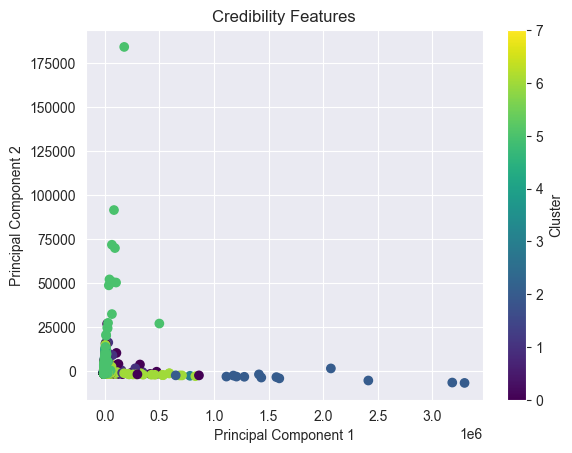

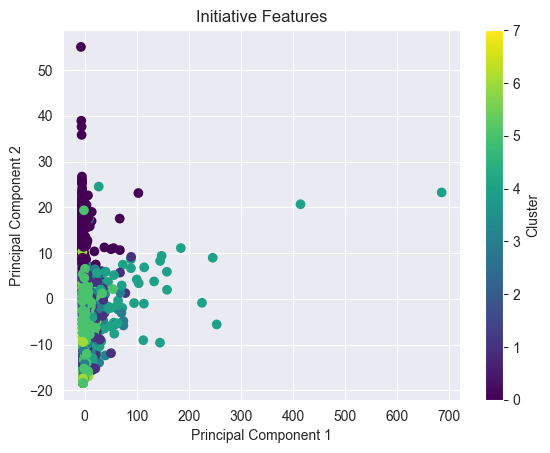

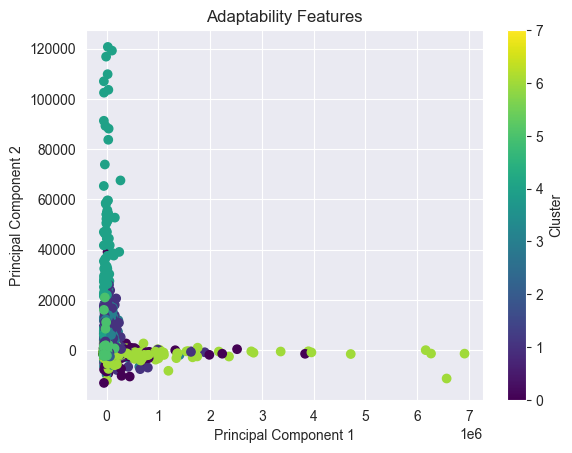

In [50]:
# Sostituisci i valori mancanti con 0
core_users_clustered = core_users_clustered.fillna(0)

# Definisci i gruppi di features
feature_groups = {
    "Credibility Features": credibility_features,
    "Initiative Features": initiative_features,
    "Adaptability Features": adaptability_features
}

def plot_2D_PCA(data, labels, title):
    """Visualizza uno scatter plot 2D dei dati PCA"""
    plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar().set_label('Cluster')
    plt.show()

# Per ogni gruppo di feature
for title, features in feature_groups.items():
    subset = core_users_clustered[features]

    # Applica PCA con 2 componenti
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(subset)

    # Visualizza lo scatter plot
    plot_2D_PCA(pca_result, core_users_clustered['kmeans_cluster_all'].values, title)




# # Creo una figura per ogni set di dati
# fig, axs = plt.subplots(len(feature_groups), 1, figsize=(10, 28))
# 
# titles = list(feature_groups.keys())
# 
# # Itero su ciascuno dei tuoi set di dati
# for i, title in enumerate(titles):
#     # Esegui PCA
#     pca = PCA(n_components=2)
#     reduced_data = pca.fit_transform(core_users_clustered[feature_groups[title]])
#     
#     ax = axs[i]
# 
#     # Aggiungo i punti al grafico
#     scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=core_users_clustered['kmeans_cluster_all'], cmap='viridis')
# 
#     # Etichette degli assi
#     ax.set_xlabel('Component 1')
#     ax.set_ylabel('Component 2')
# 
#     # Aggiungo la legenda
#     legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
#     ax.add_artist(legend1)
# 
#     # Imposto il titolo del grafico
#     ax.set_title(title)
# 
# # Visualizzo i grafici
# plt.tight_layout()
# plt.show()


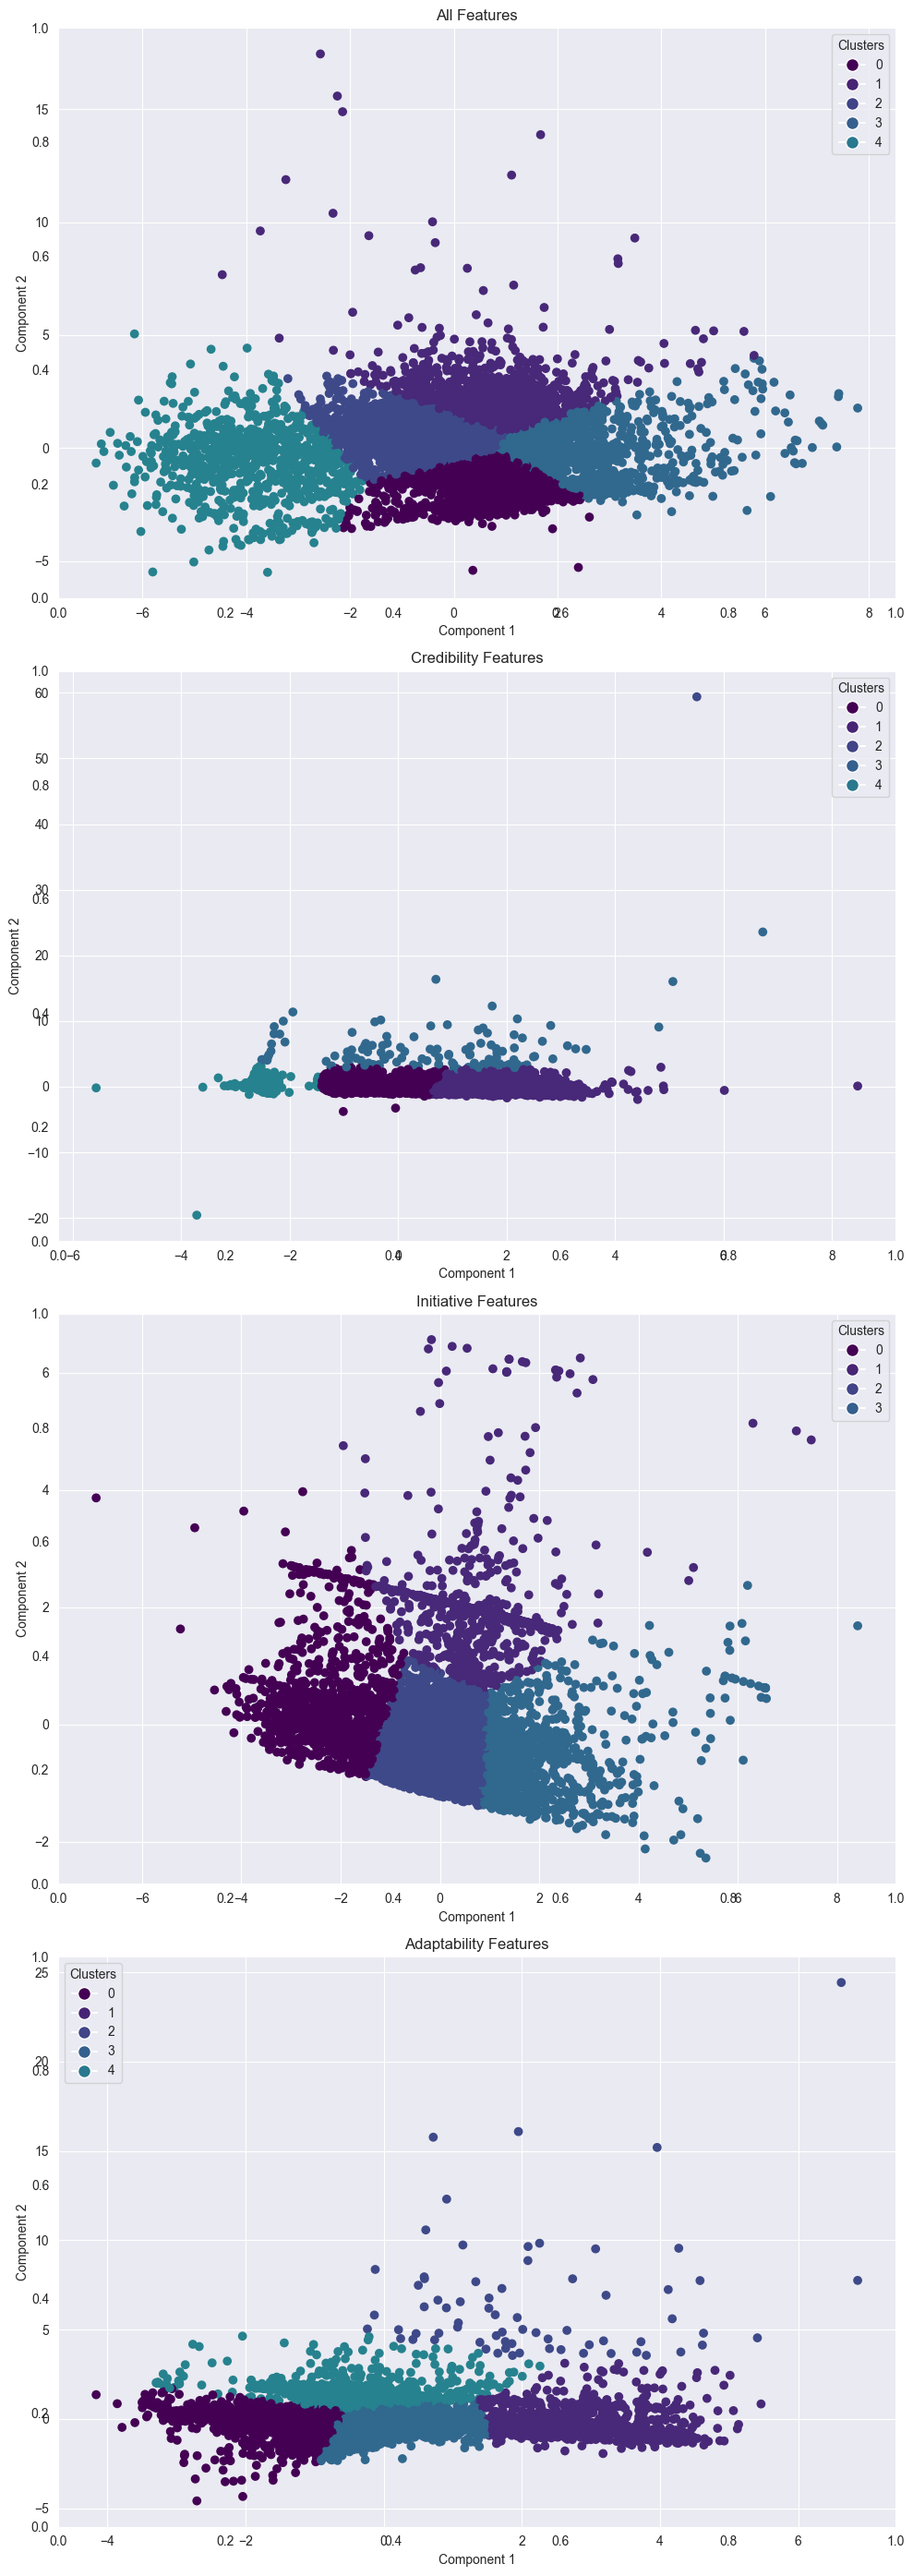

In [10]:
# # Creiamo uno scatter plot
# # plt.figure(figsize=(10, 7))
#
# # Coloriamo i punti in base al cluster a cui appartengono
# plt.scatter(core_users_pca[:, 0], core_users_pca[:, 1], c=core_users_clustering['kmeans_cluster'], cmap='viridis')
#
# plt.title('K-Means Clustering with PCA')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
#
# plt.show()



# # Creazione del grafico 3D
# fig = plt.figure(figsize=(10, 7))
# ax = fig.add_subplot(111, projection='3d')
# 
# # Aggiungi i punti al grafico
# scatter = ax.scatter(core_users_pca[:, 0], core_users_pca[:, 1], core_users_pca[:, 2], c=core_users_clustered['kmeans_cluster'], cmap='viridis')
# 
# # Aggiungi la legenda
# legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
# ax.add_artist(legend1)
# 
# # Etichette degli assi
# ax.set_xlabel('Component 1')
# ax.set_ylabel('Component 2')
# ax.set_zlabel('Component 3')
# 
# # Visualizza il grafico
# plt.show()



# # Creo una figura per ogni set di dati
# fig, axs = plt.subplots(4, 1, figsize=(10, 28))
# 
# # Imposto i nomi per i grafici
# titles = ['All Features', 'Credibility Features', 'Initiative Features', 'Adaptability Features']
# 
# # Itero su ciascuno dei tuoi set di dati
# for i, data in enumerate(core_users_pca):
#     if data.shape[1] >= 3:
#         # Creo un subplot 3D
#         ax = fig.add_subplot(4, 1, i+1, projection='3d')
#         
#         # Aggiungo i punti al grafico
#         scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=core_users_clustered[f'kmeans_cluster_{labels[i]}'], cmap='viridis')
#         
#         # Etichette degli assi
#         ax.set_xlabel('Component 1')
#         ax.set_ylabel('Component 2')
#         ax.set_zlabel('Component 3')
#     
#     else:
#         # Creo un subplot 2D
#         ax = fig.add_subplot(4, 1, i+1)
#         
#         # Aggiungo i punti al grafico
#         scatter = ax.scatter(data[:, 0], data[:, 1], c=core_users_clustered[f'kmeans_cluster_{labels[i]}'], cmap='viridis')
#         
#         # Etichette degli assi
#         ax.set_xlabel('Component 1')
#         ax.set_ylabel('Component 2')
#         
#     # Aggiungo la legenda
#     legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
#     ax.add_artist(legend1)
#     
#     # Imposto il titolo del grafico
#     ax.set_title(titles[i])
# 
# # Visualizzo i grafici
# plt.tight_layout()
# plt.show()


# from matplotlib.lines import Line2D
# 
# # Creiamo una funzione per ottenere i colori basati sul numero massimo di cluster
# def get_cluster_colors(labels, max_clusters):
#     unique_labels = np.unique(labels)
#     color_map = plt.cm.viridis(np.linspace(0, 1, max_clusters))
#     label_colors = {label: color_map[label] for label in unique_labels}
#     return [label_colors[label] for label in labels]
# 
# def create_legend(colors, labels):
#     """ Crea una legenda personalizzata """
#     legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in zip(labels, colors)]
#     return legend_elements
# 
# # Supponiamo che il numero massimo di cluster sia 10 (modificalo in base alle tue necessità)
# max_clusters = 10
# 
# # Creo una figura per ogni set di dati
# fig, axs = plt.subplots(4, 1, figsize=(10, 28))
# 
# # Imposto i nomi per i grafici
# titles = ['All Features', 'Credibility Features', 'Initiative Features', 'Adaptability Features']
# 
# # Itero su ciascuno dei tuoi set di dati
# for i, data in enumerate(core_users_pca):
#     unique_labels = np.unique(core_users_clustered[f'kmeans_cluster_{labels[i]}'])
#     colors = get_cluster_colors(core_users_clustered[f'kmeans_cluster_{labels[i]}'], max_clusters)
#     
#     if data.shape[1] >= 3:
#         # Creo un subplot 3D
#         ax = fig.add_subplot(4, 1, i+1, projection='3d')
# 
#         # Aggiungo i punti al grafico
#         scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=colors)
# 
#         # Etichette degli assi
#         ax.set_xlabel('Component 1')
#         ax.set_ylabel('Component 2')
#         ax.set_zlabel('Component 3')
# 
#     else:
#         # Creo un subplot 2D
#         ax = fig.add_subplot(4, 1, i+1)
#         
#         # Aggiungo i punti al grafico
#         scatter = ax.scatter(data[:, 0], data[:, 1], c=colors)
#         
#         # Etichette degli assi
#         ax.set_xlabel('Component 1')
#         ax.set_ylabel('Component 2')
#         
#     # Crea la legenda
#     legend_elements = create_legend([plt.cm.viridis(x) for x in unique_labels / max_clusters], unique_labels)
#     ax.legend(handles=legend_elements, title="Clusters")
#     
#     # Imposto il titolo del grafico
#     ax.set_title(titles[i])
# 
# # Visualizzo i grafici
# plt.tight_layout()
# plt.show()



## DBSCAN algorithm

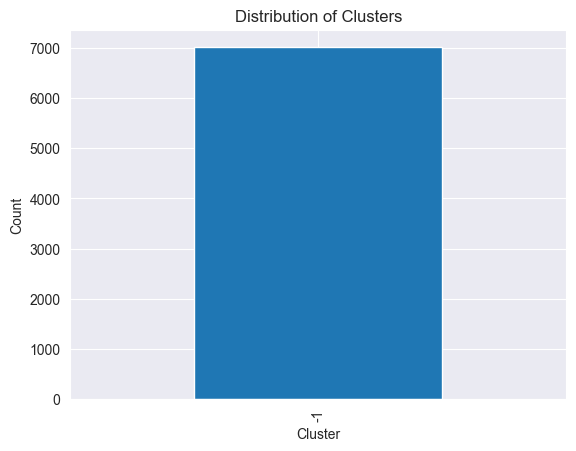

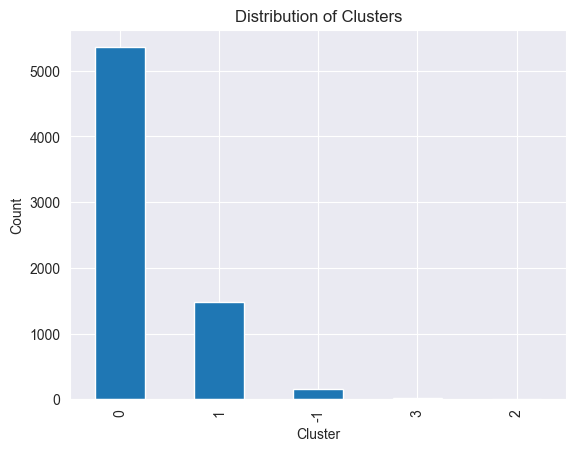

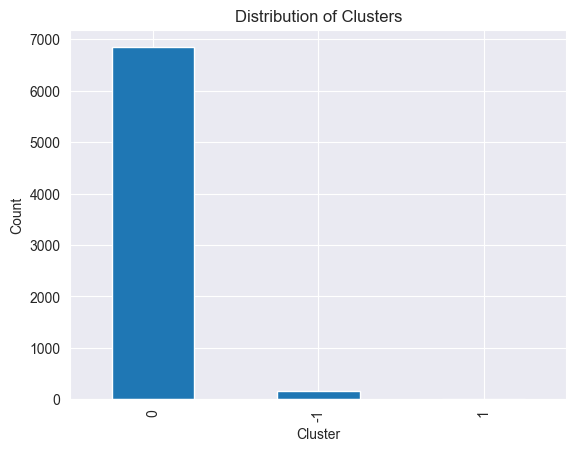

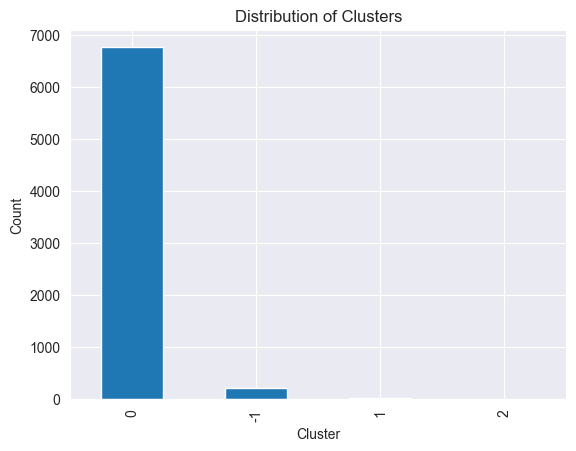

In [20]:
# # Eseguiamo DBSCAN sui dati
# db = DBSCAN(eps=0.3, min_samples=8).fit(core_users_pca[0])
# 
# # Aggiungi le etichette dei cluster ai dati
# core_users_clustered['db_cluster'] = db.labels_
# 
# # Visualizza la distribuzione dei cluster
# core_users_clustered['db_cluster'].value_counts().plot(kind='bar')
# plt.xlabel('Cluster')
# plt.ylabel('Count')
# plt.title('Distribution of Clusters')
# plt.show()



labels = ['all', 'credibility', 'initiative', 'adaptability']

for i in range(len(core_users_pca)):
    # Eseguiamo DBSCAN sui dati
    db = DBSCAN(eps=0.3, min_samples=8).fit(core_users_pca[i])
    
    # Crea il nome della colonna dinamicamente
    column_name = 'db_cluster_' + labels[i]
    
    # Aggiungi le etichette dei cluster ai dati
    core_users_clustered[column_name] = db.labels_
    
    # Visualizza la distribuzione dei cluster
    core_users_clustered[column_name].value_counts().plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.title('Distribution of Clusters')
    plt.show()


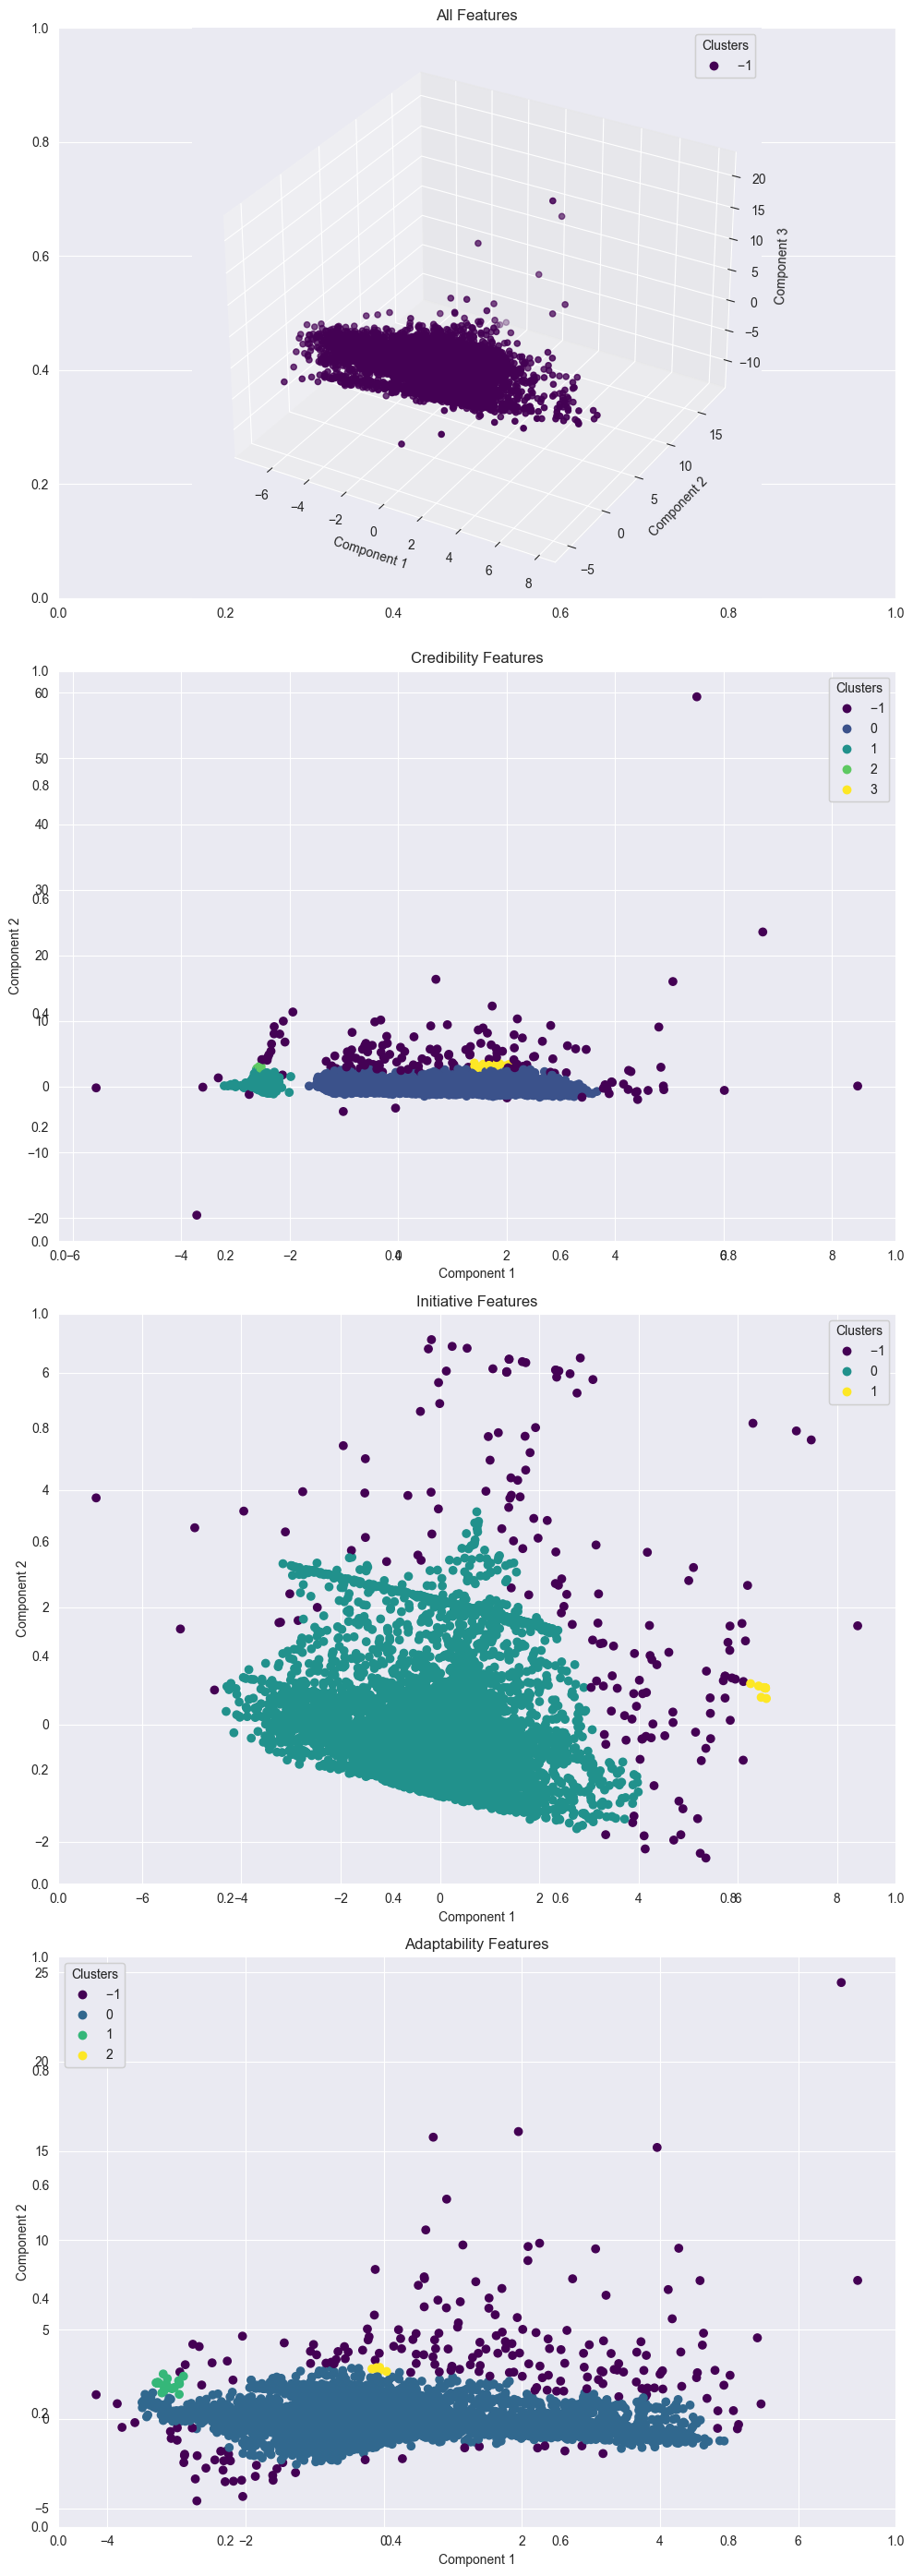

In [29]:
# # Visualizziamo i risultati
# # plt.figure(figsize=(10, 7))
# plt.scatter(core_users_pca[:, 0], core_users_pca[:, 1], c=core_users_clustering['db_cluster'])
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('DBSCAN Clustering with PCA')
# plt.show()



# Creo una figura per ogni set di dati
fig, axs = plt.subplots(4, 1, figsize=(10, 28))

# Imposto i nomi per i grafici
titles = ['All Features', 'Credibility Features', 'Initiative Features', 'Adaptability Features']

# Itero su ciascuno dei tuoi set di dati
for i, data in enumerate(core_users_pca):
    if data.shape[1] >= 3:
        # Creo un subplot 3D
        ax = fig.add_subplot(4, 1, i+1, projection='3d')
        
        # Aggiungo i punti al grafico
        scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=core_users_clustered[f'db_cluster_{labels[i]}'], cmap='viridis')
        
        # Etichette degli assi
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
    
    else:
        # Creo un subplot 2D
        ax = fig.add_subplot(4, 1, i+1)
        
        # Aggiungo i punti al grafico
        scatter = ax.scatter(data[:, 0], data[:, 1], c=core_users_clustered[f'db_cluster_{labels[i]}'], cmap='viridis')
        
        # Etichette degli assi
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        
    # Aggiungo la legenda
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    
    # Imposto il titolo del grafico
    ax.set_title(titles[i])

# Visualizzo i grafici
plt.tight_layout()
plt.show()


## HDBSCAN algorithm

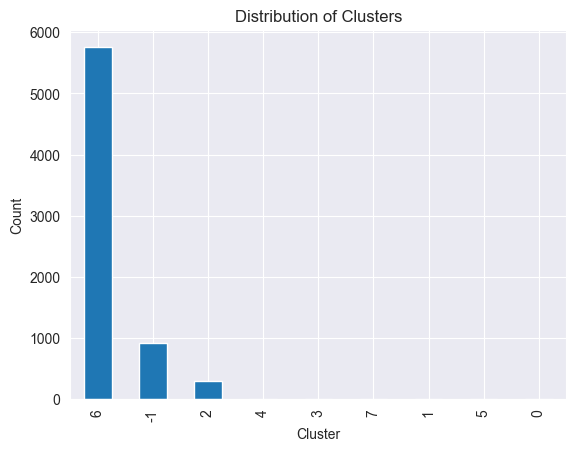

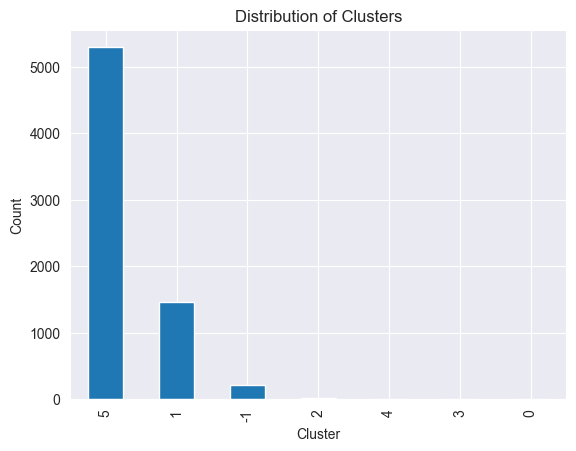

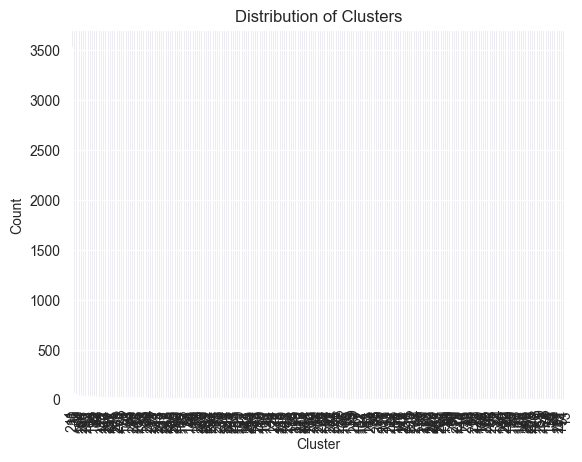

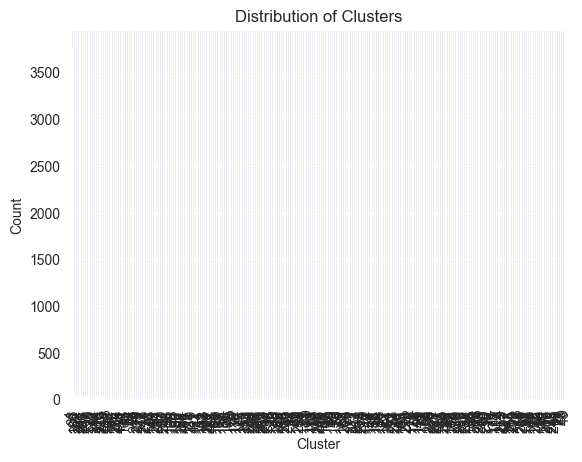

In [17]:
# # Creiamo l'istanza di HDBSCAN
# hdbscan = HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
# 
# # Facciamo il fit su core_users_pca[0]
# hdbscan_labels = hdbscan.fit_predict(core_users_pca[0])
# 
# # Aggiungiamo le etichette dei cluster ai dati
# core_users_clustered['hdbscan_cluster'] = hdbscan_labels
# 
# 
# # Visualizza la distribuzione dei cluster HDBSCAN
# core_users_clustered['hdbscan_cluster'].value_counts().plot(kind='bar')
# plt.xlabel('Cluster')
# plt.ylabel('Count')
# plt.title('Distribution of HDBSCAN Clusters')
# plt.show()



labels = ['all', 'credibility', 'initiative', 'adaptability']

for i in range(len(core_users_pca)):
    # Eseguiamo DBSCAN sui dati
    hdbscan = HDBSCAN(min_cluster_size=5, gen_min_span_tree=True).fit(core_users_pca[i])
    
    # Crea il nome della colonna dinamicamente
    column_name = 'hdbscan_cluster_' + labels[i]
    
    # Aggiungi le etichette dei cluster ai dati
    core_users_clustered[column_name] = hdbscan.labels_
    
    # Visualizza la distribuzione dei cluster
    core_users_clustered[column_name].value_counts().plot(kind='bar')
    plt.xlabel('Cluster')
    plt.ylabel('Count')
    plt.title('Distribution of Clusters')
    plt.show()


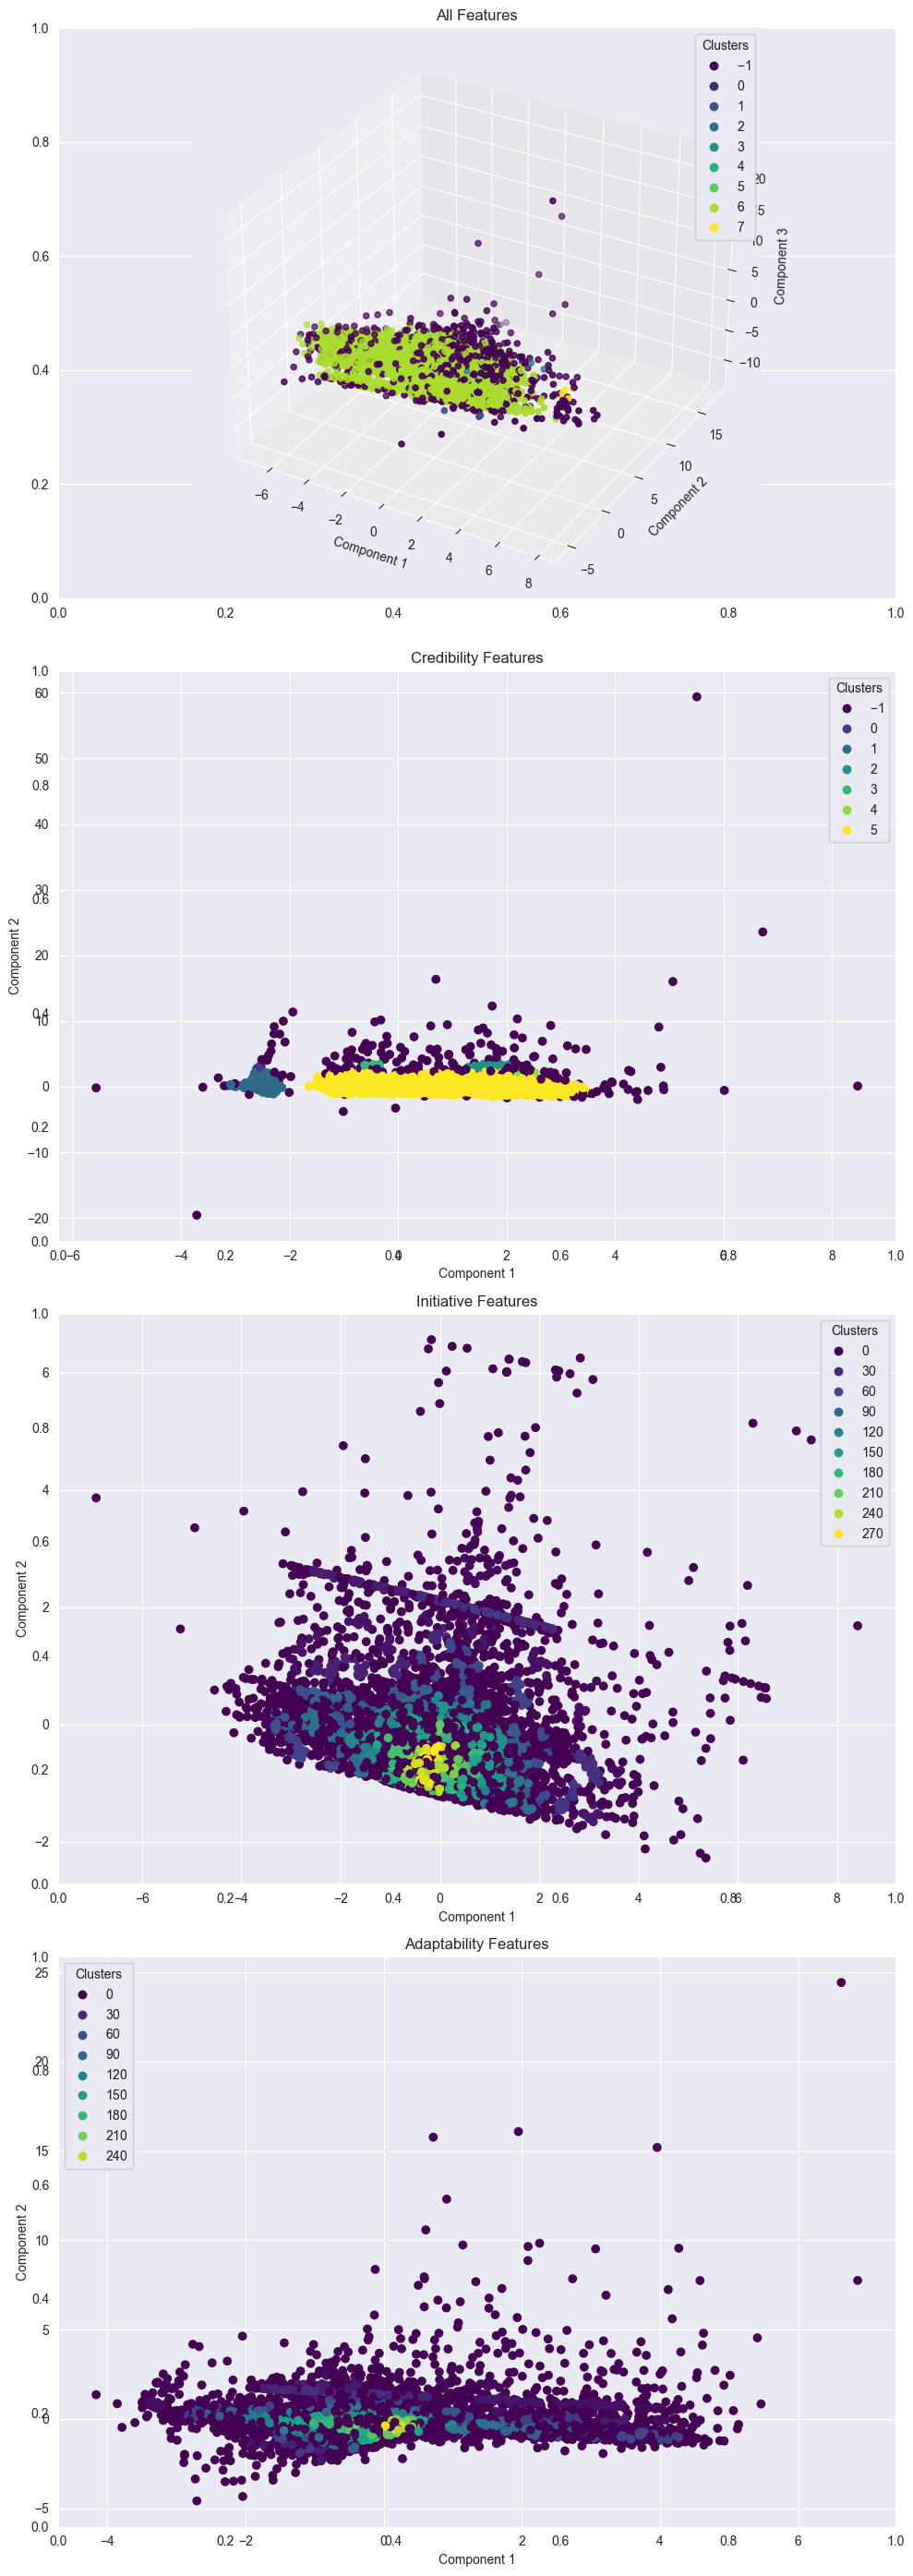

In [19]:
# Creo una figura per ogni set di dati
fig, axs = plt.subplots(4, 1, figsize=(10, 28))

# Imposto i nomi per i grafici
titles = ['All Features', 'Credibility Features', 'Initiative Features', 'Adaptability Features']

# Itero su ciascuno dei tuoi set di dati
for i, data in enumerate(core_users_pca):
    if data.shape[1] >= 3:
        # Creo un subplot 3D
        ax = fig.add_subplot(4, 1, i+1, projection='3d')
        
        # Aggiungo i punti al grafico
        scatter = ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=core_users_clustered[f'hdbscan_cluster_{labels[i]}'], cmap='viridis')
        
        # Etichette degli assi
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        ax.set_zlabel('Component 3')
    
    else:
        # Creo un subplot 2D
        ax = fig.add_subplot(4, 1, i+1)
        
        # Aggiungo i punti al grafico
        scatter = ax.scatter(data[:, 0], data[:, 1], c=core_users_clustered[f'hdbscan_cluster_{labels[i]}'], cmap='viridis')
        
        # Etichette degli assi
        ax.set_xlabel('Component 1')
        ax.set_ylabel('Component 2')
        
    # Aggiungo la legenda
    legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
    ax.add_artist(legend1)
    
    # Imposto il titolo del grafico
    ax.set_title(titles[i])

# Visualizzo i grafici
plt.tight_layout()
plt.show()


## Data Saving

In [23]:
core_users_clustered.to_csv('../data/core_users_clustered.csv', index=False)